In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import optimize as opt

from sklearn import metrics as skmetrics
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor

from skforecast.direct import ForecasterDirect, ForecasterDirectMultiVariate
from skforecast.recursive import ForecasterRecursive, ForecasterSarimax
from skforecast.sarimax import Sarimax
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster, backtesting_sarimax, grid_search_forecaster, grid_search_sarimax

import catboost
from catboost import CatBoostRegressor

import tqdm

In [2]:
df_prices = pd.read_csv('../code/data/crypto.csv', index_col='dt', parse_dates=['dt'])
df_prices.drop('TON-USDT', axis=1, inplace=True)
df_prices.columns = [c.split('-')[0] for c in df_prices.columns]
df_prices.head()

,BTC,ETH,DOT,OKB,XRP,SOL,TRX,LTC
dt,,,,,,,,
2020-01-01 19:00:00,7131.9,129.56,NaN,NaN,0.19050,NaN,0.01312,41.17
2020-01-02 19:00:00,7319.7,132.47,NaN,NaN,0.19203,NaN,0.01337,41.76
2020-01-03 19:00:00,7318.9,133.29,NaN,NaN,0.19249,NaN,0.01335,42.28
2020-01-04 19:00:00,7467.4,137.24,NaN,NaN,0.19628,NaN,0.01377,44.01
2020-01-05 19:00:00,7520.9,140.18,NaN,NaN,0.21275,NaN,0.01405,44.06


In [3]:
days_shift = 7
df_returns = df_prices.diff(days_shift) / df_prices.shift(days_shift)
df_returns = df_returns[df_returns.isna().sum(axis=1) == 0]
df_returns = df_returns[df_returns.index >= '2022-01-01']

n_observations, n_assets = df_returns.shape
print(n_observations, n_assets)
df_returns.head()

1095 8


,BTC,ETH,DOT,OKB,XRP,SOL,TRX,LTC
dt,,,,,,,,
2022-01-01 19:00:00,-0.054014,-0.067913,-0.005263,-0.048031,-0.067994,-0.110254,-0.035776,-0.023856
2022-01-02 19:00:00,-0.092438,-0.075290,-0.067066,-0.070249,-0.103108,-0.151931,-0.058294,-0.065561
2022-01-03 19:00:00,-0.041478,-0.012844,0.008603,-0.035905,-0.054473,-0.072116,-0.022158,-0.004834
2022-01-04 19:00:00,-0.028151,0.006730,0.044412,-0.048068,-0.019920,-0.045850,-0.012687,-0.005669
2022-01-05 19:00:00,-0.088865,-0.083878,-0.050395,-0.093272,-0.089935,-0.138798,-0.092972,-0.086360


In [76]:
threshold_date = '2023-10-01'
df_returns_test = df_returns[df_returns.index >= threshold_date]
df_returns_train = df_returns[df_returns.index < threshold_date]
df_returns_train.shape, df_returns_test.shape

((637, 8), (458, 8))

In [5]:
def mse_last_value(y_true, y_pred):
    idxs = range(0, len(y_true), days_shift)
    return skmetrics.mean_squared_error(y_true.iloc[idxs], y_pred.iloc[idxs])

In [6]:
# HP optimization
cv = TimeSeriesFold(
    steps=days_shift,
    initial_train_size=50,
    refit=False,
)

lags_grid = {
    '0': 1,
    '1': range(1, 4),
    '2': range(1, 8),
    '3': range(1, 15),
}

arima_params = {
    'order': [
        (1, 0, 0),
        (0, 0, 1),
        (1, 0, 1),
        (1, 1, 1),
        (2, 0, 2),
        (2, 1, 2),
    ]
}

model_grid = [
    (LinearRegression, {}),
    (RandomForestRegressor, {'n_estimators': [10, 50, 100], 'random_state': [27]}),
]

best_models = {}
for c in df_returns.columns:
    # ARMA
    train_data = df_returns_train[c].reset_index(drop=True)
    model_name = f'ARIMA'
    forecaster = ForecasterSarimax(
                regressor=Sarimax(),
                forecaster_id=f'ARIMA_{c}'
                )
    metric = grid_search_sarimax(
                forecaster=forecaster,
                y=train_data,
                param_grid=arima_params,
                cv=cv,
                metric=mse_last_value,
                return_best=True,
                n_jobs='auto',
                verbose=False,
                show_progress=True
            )
    if best_models.get(model_name) is None:
        best_models[model_name] = []
    best_models[model_name].append(forecaster)

    # ML
    for model_builder, params in model_grid:
        train_data = df_returns_train[c].reset_index(drop=True)
        model_name = model_builder.__name__
        forecaster = ForecasterRecursive(
                    regressor=model_builder(),
                    lags=range(1, 8),
                    forecaster_id=f'{model_name}_{c}'
                )
        metric = grid_search_forecaster(
                      forecaster=forecaster,
                      y=train_data,
                      param_grid=params,
                      lags_grid=lags_grid,
                      cv=cv,
                      metric=mse_last_value,
                      return_best=True,
                      n_jobs='auto',
                      verbose=False,
                      show_progress=True
                  )
        if best_models.get(model_name) is None:
            best_models[model_name] = []
        best_models[model_name].append(forecaster)




Number of models compared: 6.


params grid:   0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


`Forecaster` refitted using the best-found parameters, and the whole data set: 
  Parameters: {'order': (1, 0, 1)}
  Backtesting metric: 0.0018566341320904916



lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {}
  Backtesting metric: 0.0018661813561750102


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'n_estimators': 50, 'random_state': 27}
  Backtesting metric: 0.00204335426833109
Number of models compared: 6.


params grid:   0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


`Forecaster` refitted using the best-found parameters, and the whole data set: 
  Parameters: {'order': (2, 0, 2)}
  Backtesting metric: 0.002388949446801113



lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {}
  Backtesting metric: 0.001982499431800834


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'n_estimators': 100, 'random_state': 27}
  Backtesting metric: 0.0033748679740207726
Number of models compared: 6.


params grid:   0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


`Forecaster` refitted using the best-found parameters, and the whole data set: 
  Parameters: {'order': (1, 0, 1)}
  Backtesting metric: 0.002790626039926123



lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1] 
  Parameters: {}
  Backtesting metric: 0.0029326378521768587


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'n_estimators': 100, 'random_state': 27}
  Backtesting metric: 0.0052853029388361
Number of models compared: 6.


params grid:   0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization f

`Forecaster` refitted using the best-found parameters, and the whole data set: 
  Parameters: {'order': (2, 0, 2)}
  Backtesting metric: 0.0022006471363136436



C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1] 
  Parameters: {}
  Backtesting metric: 0.0026537195517264927


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1] 
  Parameters: {'n_estimators': 10, 'random_state': 27}
  Backtesting metric: 0.005556305535230093
Number of models compared: 6.


params grid:   0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-s

`Forecaster` refitted using the best-found parameters, and the whole data set: 
  Parameters: {'order': (1, 0, 0)}
  Backtesting metric: 0.0018658978972954288



lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1] 
  Parameters: {}
  Backtesting metric: 0.0018602494542877355


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'n_estimators': 50, 'random_state': 27}
  Backtesting metric: 0.003609017569316223
Number of models compared: 6.


params grid:   0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary

`Forecaster` refitted using the best-found parameters, and the whole data set: 
  Parameters: {'order': (2, 0, 2)}
  Backtesting metric: 0.005445414009862594



lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {}
  Backtesting metric: 0.005631254861294191


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'n_estimators': 10, 'random_state': 27}
  Backtesting metric: 0.01152428919480692
Number of models compared: 6.


params grid:   0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


`Forecaster` refitted using the best-found parameters, and the whole data set: 
  Parameters: {'order': (1, 0, 0)}
  Backtesting metric: 0.0013261126147331125



lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1] 
  Parameters: {}
  Backtesting metric: 0.001347812093587086


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'n_estimators': 100, 'random_state': 27}
  Backtesting metric: 0.0013623955834393706
Number of models compared: 6.


params grid:   0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

`Forecaster` refitted using the best-found parameters, and the whole data set: 
  Parameters: {'order': (2, 0, 2)}
  Backtesting metric: 0.002402091257174189



lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {}
  Backtesting metric: 0.002284321762459985


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'n_estimators': 100, 'random_state': 27}
  Backtesting metric: 0.0030304460825993553


In [7]:
best_models.keys()

dict_keys(['ARIMA', 'LinearRegression', 'RandomForestRegressor'])

In [13]:
# evaluate models on test data
cv = TimeSeriesFold(
    steps=days_shift,
    initial_train_size=50,
    refit=True,
)
backtest_metrics = {}

for model_type, models in best_models.items():
    if model_type == 'ARIMA':
        for c, forecaster in zip(df_returns_test.columns, models):
            data_test = df_returns_test[c].reset_index(drop=True)
            metric, predictions = backtesting_sarimax(
                          forecaster=forecaster,
                          y=data_test,
                          cv=cv,
                          metric=mse_last_value,
                          n_jobs=-1,
                      )
            if backtest_metrics.get(model_type) is None:
                backtest_metrics[model_type] = []
            backtest_metrics[model_type].append(metric.values.item())
    else:
        for c, forecaster in zip(df_returns_test.columns, models):
            data_test = df_returns_test[c].reset_index(drop=True)
            metric, pred = backtesting_forecaster(
                forecaster=forecaster,
                y=data_test,
                cv=cv,
                metric=mse_last_value,
                n_jobs=-1,
            )
            if backtest_metrics.get(model_type) is None:
                backtest_metrics[model_type] = []
            backtest_metrics[model_type].append(metric.values.item())
            

  0%|          | 0/46 [00:00<?, ?it/s]

C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

In [14]:
# mse on test data
pd.DataFrame(backtest_metrics, index=df_returns.columns) * 1000

,ARIMA,LinearRegression,RandomForestRegressor
BTC,1.442721,1.356486,1.741507
ETH,1.277838,2.321226,2.434864
DOT,3.496550,3.359889,4.321601
OKB,1.539599,1.470619,1.656432
XRP,3.703069,3.751702,5.334308
SOL,4.261678,4.076402,5.529980
TRX,5.596668,5.782195,11.546909
LTC,1.993605,1.639787,2.545554


In [72]:
def portfolio_optimizer(mu_hat, cov_hat, tau):
    def objective(w):
        w = w.reshape((-1, 1))
        return (w.T @ cov_hat @ w - tau * w.T @ mu_hat).item()
        
    def unit_portfolio(w):
        return np.abs(w).sum() - 1
        
    eq_cons = {
        'type': 'eq',
        'fun': unit_portfolio,
    }
    bounds = [(-1, 1) for i in range(n_assets)]
    x0 = np.ones(n_assets) / n_assets
    sol = opt.minimize(
        fun=objective,
        x0=x0,
        method='SLSQP',
        bounds=bounds,
        constraints=[eq_cons]
    )
    if sol.success:
        return sol.x

In [54]:
def frontier_evaluator(mu_hat, cov_hat, ret_true, frontier_tau):
    frontier = np.full_like(frontier_tau, np.nan)
    for i in range(len(frontier_tau)):
        tau = frontier_tau[i]
        w = portfolio_optimizer(mu_hat, cov_hat, tau)
        if w is None:
            print('not converged')
            continue
        roi = np.dot(w, ret_true)
        frontier[i] = roi
    return frontier

In [55]:
# mu estimators

def naive_estimator(df_hist):
    return df_hist.mean(axis=0)

def martingal_estimator(df_hist):
    return df_hist.iloc[-1]

def ml_estimator_builder(models):
    def func(df_hist):
        mu_hat = []
        for c, forecaster in zip(df_hist.columns, models):
            y = df_hist[c].reset_index(drop=True)
            forecaster.fit(y)
            mu_hat.append(forecaster.predict(days_shift).iloc[-1])
        return np.array(mu_hat)
    return func

In [56]:
n_assets = df_returns.shape[1]

idx_most_risky = np.argmax(df_returns_train.describe().T['std'])
idx_less_risky = np.argmin(df_returns_train.describe().T['std'])
idx_best_return = np.argmax(df_returns_train.describe().T['mean'])
idx_worst_return = np.argmin(df_returns_train.describe().T['mean'])
print(idx_most_risky, idx_less_risky, idx_best_return, idx_worst_return)

def single_asset_portfolio_builder(idx):
    w =  np.zeros(n_assets)
    w[idx] = 1
    return w

def uniform_portfolio_builder():
    return np.full(n_assets, 1 / n_assets)


5 6 3 2


In [57]:
best_models.keys()

dict_keys(['ARIMA', 'LinearRegression', 'RandomForestRegressor'])

In [58]:
results_frontier = []
results_trivial = []

min_history_leng = 91
total_runs = df_returns_test.shape[0] - days_shift - min_history_leng
print(total_runs)
frontier_tau = np.linspace(0.01, 1, 5)

mu_estimators = [
    ('naive', naive_estimator),
    ('martingal', martingal_estimator),
    ('lr', ml_estimator_builder(best_models['LinearRegression'])),
    ('arima', ml_estimator_builder(best_models['ARIMA'])),
    ('rf', ml_estimator_builder(best_models['RandomForestRegressor'])),
]

trivial_portfolios = [
    ('uniform', uniform_portfolio_builder()),
    ('most_risky', single_asset_portfolio_builder(idx_most_risky)),
    ('less_risky', single_asset_portfolio_builder(idx_less_risky)),
    ('best_return', single_asset_portfolio_builder(idx_best_return)),
    ('worst_return', single_asset_portfolio_builder(idx_worst_return)),
]

for t in tqdm.trange(total_runs):
    # prepare data
    idx_history = min_history_leng + t
    idx_future = idx_history + days_shift - 1
    df_history = df_returns_test.iloc[:idx_history]
    df_future = df_returns_test.iloc[idx_future]

    # estimate cov, common for all models
    cov_hat = df_history.cov().values

    # estimate mu using list of models
    frontiers = []
    for name, mu_estimator in mu_estimators:
        mu_hat = mu_estimator(df_history)
        
        # evaluate each portfolio in frontier for currnet model
        roi_frontier = frontier_evaluator(mu_hat, cov_hat, df_future.values, frontier_tau)
        frontiers.append(roi_frontier)
    results_frontier.append(frontiers)
    
    # evaluate trivial strategies 
    trivials = []
    for name, w in trivial_portfolios:
        roi = np.dot(w, df_future.values).item()
        trivials.append(roi)
    results_trivial.append(trivials)


293


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

not converged
not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary

not converged
not converged
not converged
not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary

not converged
not converged
not converged


  4%|███▎                                                                               | 2/50 [00:05<02:22,  2.98s/it]

not converged
not converged
not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary

not converged
not converged


  6%|████▉                                                                              | 3/50 [00:09<02:24,  3.07s/it]

not converged
not converged
not converged
not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary

not converged


  8%|██████▋                                                                            | 4/50 [00:12<02:21,  3.07s/it]

not converged
not converged
not converged
not converged
not converged
not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary

not converged


 10%|████████▎                                                                          | 5/50 [00:15<02:19,  3.10s/it]

not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization f

not converged


 12%|█████████▉                                                                         | 6/50 [00:18<02:15,  3.07s/it]

not converged
not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization f

not converged
not converged


 14%|███████████▌                                                                       | 7/50 [00:21<02:12,  3.09s/it]

not converged
not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization f

not converged
not converged
not converged
not converged
not converged
not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 18%|██████████████▉                                                                    | 9/50 [00:27<02:05,  3.07s/it]

not converged
not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum

not converged


 20%|████████████████▍                                                                 | 10/50 [00:30<02:03,  3.10s/it]

not converged
not converged
not converged
not converged
not converged
not converged


 22%|██████████████████                                                                | 11/50 [00:33<02:00,  3.08s/it]

not converged
not converged
not converged
not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 24%|███████████████████▋                                                              | 12/50 [00:36<01:55,  3.04s/it]

not converged
not converged
not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


not converged
not converged


 26%|█████████████████████▎                                                            | 13/50 [00:39<01:53,  3.07s/it]

not converged


 28%|██████████████████████▉                                                           | 14/50 [00:42<01:50,  3.06s/it]

not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 30%|████████████████████████▌                                                         | 15/50 [00:45<01:46,  3.03s/it]

not converged
not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization f

not converged
not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 34%|███████████████████████████▉                                                      | 17/50 [00:52<01:41,  3.08s/it]

not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-inver

not converged
not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 40%|████████████████████████████████▊                                                 | 20/50 [01:01<01:34,  3.16s/it]

not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

not converged
not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary

not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary

not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary

not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary

not converged


 54%|████████████████████████████████████████████▎                                     | 27/50 [01:23<01:09,  3.04s/it]

not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary

not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization f

not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary

not converged
not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization f

not converged


 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:49<00:41,  2.96s/it]

not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary

not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

not converged
not converged


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:58<00:32,  2.98s/it]

not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization f

not converged


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [02:04<00:27,  3.10s/it]

not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

not converged
not converged
not converged


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [02:07<00:24,  3.10s/it]

not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

not converged
not converged


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [02:11<00:21,  3.13s/it]

not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary

not converged
not converged


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [02:14<00:19,  3.20s/it]

not converged
not converged
not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary

not converged
not converged
not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary

not converged


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:20<00:12,  3.12s/it]

not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary

not converged


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:26<00:06,  3.10s/it]

not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary

not converged
not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

not converged
not converged


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:32<00:00,  3.11s/it]

not converged
not converged
not converged


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:32<00:00,  3.06s/it]


In [66]:
frontier_means = np.nanmean(results_frontier, axis=0)
frontier_stds = np.nanstd(results_frontier, axis=0)

trivial_means = np.mean(results_trivial, axis=0)
trivial_stds = np.std(results_trivial, axis=0)

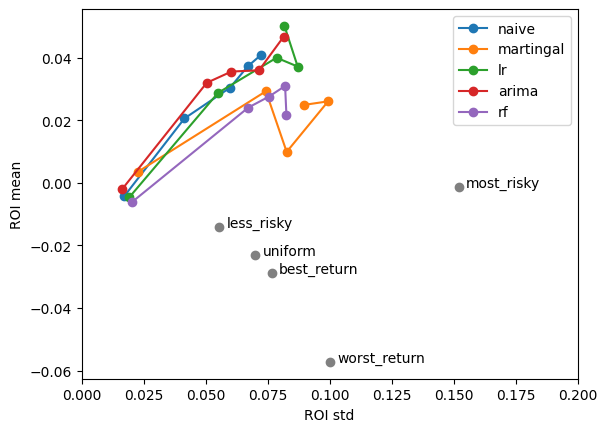

In [67]:
fig, ax = plt.subplots()
for m, s, (label, _) in zip(frontier_means, frontier_stds, mu_estimators):
    ax.plot(s, m, marker='o', label=label)

ax.scatter(trivial_stds, trivial_means, color='grey')
for s, m, (name, _) in zip(trivial_stds, trivial_means, trivial_portfolios):
    ax.text(s + 0.003, m, name)
    
ax.set_xlabel('ROI std')
ax.set_ylabel('ROI mean')
ax.set_xlim(0, 0.2)
ax.legend()

In [68]:
np.isnan(results_frontier).mean(axis=0)

array([[0.  , 0.02, 0.  , 0.02, 0.02],
       [0.  , 0.22, 0.3 , 0.34, 0.28],
       [0.  , 0.06, 0.1 , 0.18, 0.18],
       [0.  , 0.04, 0.1 , 0.18, 0.2 ],
       [0.  , 0.16, 0.18, 0.2 , 0.18]])

In [69]:
# mean ROI
pd.DataFrame(frontier_means, columns=frontier_tau, index=[n for n, _ in mu_estimators])

,0.0100,0.2575,0.5050,0.7525,1.0000
naive,-0.004275,0.020566,0.030397,0.037229,0.040802
martingal,0.003619,0.029257,0.009894,0.026039,0.024897
lr,-0.004542,0.028736,0.039968,0.037150,0.050129
arima,-0.001987,0.031959,0.035560,0.035951,0.046736
rf,-0.006245,0.024062,0.027553,0.030950,0.021562


In [70]:
# std ROI
pd.DataFrame(frontier_stds, columns=frontier_tau, index=[n for n, _ in mu_estimators])

,0.0100,0.2575,0.5050,0.7525,1.0000
naive,0.017161,0.041437,0.059821,0.066980,0.072234
martingal,0.022848,0.074289,0.082669,0.099377,0.089591
lr,0.019281,0.054975,0.078603,0.087109,0.081771
arima,0.016354,0.050430,0.060398,0.071517,0.081498
rf,0.020127,0.067207,0.075507,0.082036,0.082574


In [71]:

pd.DataFrame({
    'mean': trivial_means,
    'std': trivial_stds,
}, index=[n for n, _ in trivial_portfolios])

,mean,std
uniform,-0.023108,0.070013
most_risky,-0.001176,0.151964
less_risky,-0.014059,0.055378
best_return,-0.028795,0.076568
worst_return,-0.057186,0.100200
